In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg

# Modèle EM - Frenquency domaine

In [2]:
# Modèle de resistivité :
res_map = np.empty((30,50),dtype='float')
res_map[0:10,:] = 1/1e-3
res_map[10:20,:] = 1/1e-4
res_map[20:30,:] = 2/1e-3

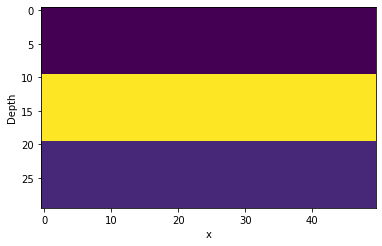

In [3]:
plt.imshow(res_map)
plt.xlabel('x')
plt.ylabel('Depth');

In [4]:
position_x = 24 # position initiale du modèle
noiseEM = 1 
nlay = 100
thickness = 1

thk = pg.Vector(nlay - 1, thickness)  # épaisseur de chaque couche (1m)
centroids = np.cumsum(thk)-thk/2 # centroïde des couches

# On sample dans le model "res_map" la résistivité correspondant aux position de couches. 
res_EM = np.ones(nlay) *  res_map[0,position_x]

In [23]:
centroids

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
       77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
       88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5])

Inversion de l'indexing :

- référence en bas à gauche et en haut à gauche

- si on prend le 0 du premier modèle il faut le placer dans le 0 de l'autre et inversément
    

In [27]:
for i in centroids:
    print(i)
    if i < 30:
        ab = 29 - np.round((i-0.01)).astype(int) # index dans le modèle resmap
        ab2 = np.floor(i/thickness).astype(int) # index dans le modèle EM
        res_EM[ab2] = res_map[ab,position_x]

0.5
1.5
2.5
3.5
4.5
5.5
6.5
7.5
8.5
9.5
10.5
11.5
12.5
13.5
14.5
15.5
16.5
17.5
18.5
19.5
20.5
21.5
22.5
23.5
24.5
25.5
26.5
27.5
28.5
29.5
30.5
31.5
32.5
33.5
34.5
35.5
36.5
37.5
38.5
39.5
40.5
41.5
42.5
43.5
44.5
45.5
46.5
47.5
48.5
49.5
50.5
51.5
52.5
53.5
54.5
55.5
56.5
57.5
58.5
59.5
60.5
61.5
62.5
63.5
64.5
65.5
66.5
67.5
68.5
69.5
70.5
71.5
72.5
73.5
74.5
75.5
76.5
77.5
78.5
79.5
80.5
81.5
82.5
83.5
84.5
85.5
86.5
87.5
88.5
89.5
90.5
91.5
92.5
93.5
94.5
95.5
96.5
97.5
98.5


Mise en commun des modèles

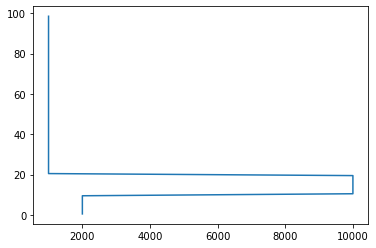

In [6]:
model = pg.cat(thk, res_EM)
noiseEM = 1
plt.plot(np.array(res_EM)[:-1],np.array(centroids));

Fréquences utilisées

In [7]:
coilspacing = 10
nf = 10
freq = pg.Vector(nf)
freq[0] = 100
freq[1] = 400
freq[2] = 600
freq[3] = 1000
freq[4] = 5000
freq[5] = 8000
freq[6] = 9000
freq[7] = 10000
freq[8] = 20000
freq[9] = 30000

Fonction du modèle

In [8]:
fEM = pg.core.FDEM1dModelling(nlay, freq, coilspacing) # coilspacing : espacement des boucles
dataEM = fEM(model)

Bruit possible :

In [9]:
for i in range(len(dataEM)):
    dataEM[i] += np.random.random(1)[0] * 0.1

Plot du modèle :

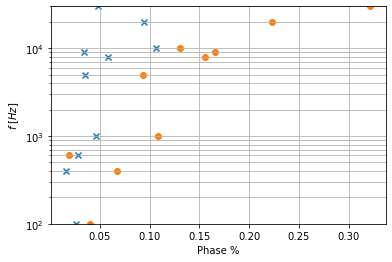

In [10]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

Alternative qui utilise des fonctions équivalentes 

In [11]:
#Une autre méthode pour comparer. Ca a l'air de donner les memes datas
Data_box_FEM = pg.physics.em.FDEM(x=[1],freqs=freq,coilSpacing=coilspacing)
FOP = pg.core.FDEM1dRhoModelling(centroids, Data_box_FEM.freq(), Data_box_FEM.coilSpacing,-Data_box_FEM.height)
dataEM = FOP(res_EM)

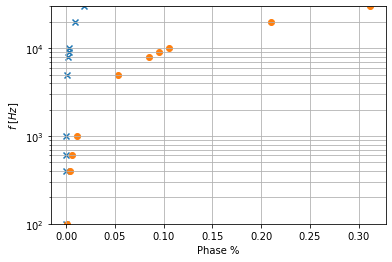

In [12]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

## Inversion FDEM

But : retrouver notre modèle initial à partir des données

In [13]:
transRhoa = pg.trans.TransLog() # paramètre initial - no limit sur les couches
transThk = pg.trans.TransLog()
transRes = pg.trans.TransLogLU(1., 1000.) # limitation des résistivités - entre 1 et 1000 ohmm
transEM = pg.trans.Trans()

nombre de couche au modèle

In [14]:
nLayer_inv = 20 # nombre de layer du modèle inverse

Modèle initial, avant inversion. 2m de couches, uniformes à 10 ohmm

In [15]:
thk_inv = pg.Vector(nLayer_inv - 1, 2)  # 2m d'épaisseur par couches
res_inv = np.ones(nLayer_inv) *  1000
initial_model = pg.cat(thk_inv, res_inv)  # mise en commun du modèle

In [16]:
fEM_inv = pg.core.FDEM1dModelling(nLayer_inv, freq, coilspacing)
fEM_inv.region(0).setTransModel(transThk)
fEM_inv.region(1).setTransModel(transRes)
lamEM =  100 # paramètre de régulation pour le modèle

Les fameux modèles -> non uniqueness des solutions qui dépendent des paramètres.

In [17]:
invEM = pg.core.Inversion(dataEM, fEM_inv, transEM)
invEM.setModel(initial_model)
invEM.setRelativeError(0.1/100)
invEM.setLambda(lamEM)
invEM.setMarquardtScheme(0.8)
invEM.setDeltaPhiAbortPercent(0.00001)
invEM.setMaxIter(40)
invEM.setBlockyModel(True)

Finalisation du modèle EM

In [18]:
modelEM = invEM.run()
respEM = invEM.response()

Données

In [19]:
np.array(modelEM)

array([  1.99520763,   1.99100241,   1.99685006,   1.99823666,
         1.99980207,   2.00168796,   1.99843475,   2.00221607,
         2.00004359,   2.00287567,   1.9995029 ,   2.00292641,
         1.99938451,   2.00233318,   1.99939189,   2.00222389,
         1.99950358,   2.00221817,   1.99788926, 999.99999001,
       999.99999001, 999.99999001, 999.99999001, 999.99999001,
       999.99999001, 999.99999001, 999.99999001, 999.99999001,
       999.99999   , 999.99999   , 999.99999   , 999.99999   ,
       999.99999   , 999.99999   , 999.99999   , 999.99999   ,
       999.99999   , 999.99999   , 999.99999007])

Plot

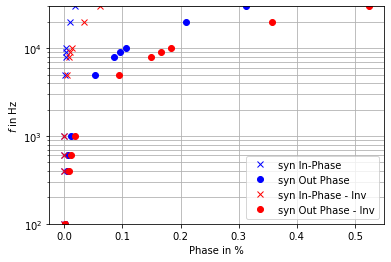

In [20]:
plt.semilogy(dataEM[0:nf], freq, 'bx', label='syn In-Phase')
plt.semilogy(dataEM[nf:nf*2], freq, 'bo', label='syn Out Phase')
plt.semilogy(respEM[0:nf], freq, 'rx', label='syn In-Phase - Inv')
plt.semilogy(respEM[nf:nf*2], freq, 'ro', label='syn Out Phase - Inv')
plt.ylim((min(freq), max(freq)))
plt.xlabel("Phase in %")
plt.ylabel("$f$ in Hz")
plt.grid(which='both')
plt.legend(loc="best");

Reconstruction du modèle initial

In [21]:
model_Final = np.array(modelEM)
cetr = np.cumsum(model_Final[0:nLayer_inv-2])
res_Final = model_Final[nLayer_inv-1:-2]

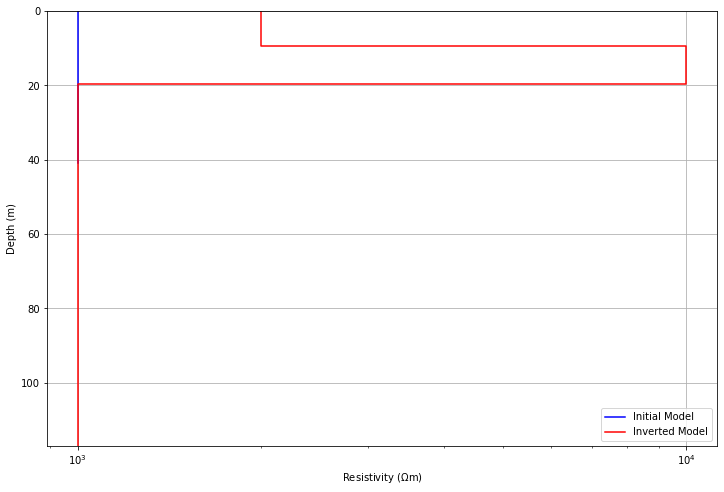

In [22]:
fig, ax = plt.subplots(figsize = ((12,8)))
pg.viewer.mpl.drawModel1D(ax, values=res_Final, depths=cetr,plot='semilogx', 
                          color='blue',label='Initial Model')
pg.viewer.mpl.drawModel1D(ax, values=res_EM[:-1], depths=centroids,plot='semilogx', 
                          color='red',label='Inverted Model')
plt.legend();